## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas")

✓ Librerías importadas


## 2. Cargar Datos

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

test_ids = df_test['ID'].copy()

print(f"Train: {df_train.shape[0]:,} registros")
print(f"Test: {df_test.shape[0]:,} registros")

Train: 692,500 registros
Test: 296,786 registros


## 3. Preprocesamiento Optimizado para Redes Neuronales

In [3]:
def preprocess_for_nn(df):
    """
    Preprocesamiento optimizado para redes neuronales
    """
    df = df.copy()
    
    # Eliminar columnas (incluyendo duplicados)
    cols_to_drop = ['ID', 'PERIODO_ACADEMICO']
    if 'F_TIENEINTERNET.1' in df.columns:
        cols_to_drop.append('F_TIENEINTERNET.1')
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Variables binarias
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 
                   'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].fillna('No')
            df[col] = df[col].map({'Si': 1, 'No': 0}).fillna(0)
    
    if 'E_PRIVADO_LIBERTAD' in df.columns:
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].fillna('N')
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0}).fillna(0)
    
    # Estrato
    estrato_map = {'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3,
                   'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6, 'Sin Estrato': 0}
    if 'F_ESTRATOVIVIENDA' in df.columns:
        df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].fillna('Sin Estrato')
        df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].map(estrato_map).fillna(0)
    
    # Horas trabajo
    horas_map = {'Menos de 10 horas': 5, 'Entre 11 y 20 horas': 15.5, 
                 'Entre 21 y 30 horas': 25.5, 'Más de 30 horas': 35, '0': 0}
    if 'E_HORASSEMANATRABAJA' in df.columns:
        df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].fillna('0')
        df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].map(horas_map).fillna(0)
    
    # Valor matrícula
    valor_map = {'Menos de 500 mil': 0.25, 'Entre 500 mil y menos de 1 millón': 0.75,
                 'Entre 1 millón y menos de 2.5 millones': 1.75, 
                 'Entre 2.5 millones y menos de 4 millones': 3.25,
                 'Entre 4 millones y menos de 5.5 millones': 4.75,
                 'Entre 5.5 millones y menos de 7 millones': 6.25,
                 'Más de 7 millones': 7.75, 'No pagó matrícula': 0}
    if 'E_VALORMATRICULAUNIVERSIDAD' in df.columns:
        df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].fillna('No pagó matrícula')
        df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].map(valor_map).fillna(0)
    
    # Educación padres
    edu_map = {'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
               'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
               'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
               'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
               'Postgrado': 9, 'No sabe': 0, 'No Aplica': 0}
    for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']:
        if col in df.columns:
            df[col] = df[col].fillna('No sabe')
            df[col] = df[col].map(edu_map).fillna(0)
    
    # Label encoding
    for col in ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].fillna('DESCONOCIDO'))
    
    return df

print("✓ Función de preprocesamiento definida")

✓ Función de preprocesamiento definida


In [4]:
# Aplicar preprocesamiento
df_train_proc = preprocess_for_nn(df_train)
df_test_proc = preprocess_for_nn(df_test)

print("✓ Preprocesamiento aplicado")

✓ Preprocesamiento aplicado


## 4. Feature Engineering Básico

In [5]:
def basic_features(df):
    """
    Feature engineering básico
    """
    df = df.copy()
    
    # Promedio de indicadores
    df['INDICADOR_PROMEDIO'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].mean(axis=1)
    
    # Desviación estándar de indicadores
    df['INDICADOR_STD'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].std(axis=1)
    
    # Educación familiar promedio
    if all(col in df.columns for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']):
        df['EDUCACION_FAMILIAR'] = (df['F_EDUCACIONPADRE'] + df['F_EDUCACIONMADRE']) / 2
    
    return df

# Aplicar
df_train_fe = basic_features(df_train_proc)
df_test_fe = basic_features(df_test_proc)

print(f"✓ Features creadas: {df_train_fe.shape[1]} columnas")

✓ Features creadas: 21 columnas


## 5. Preparar Datos y Normalizar

In [6]:
# Separar X e y
X = df_train_fe.drop('RENDIMIENTO_GLOBAL', axis=1)
y = df_train_fe['RENDIMIENTO_GLOBAL']

# Eliminar NaN
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"Registros válidos: {len(y):,}")

# Codificar target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain: {X_train.shape[0]:,}")
print(f"Validation: {X_val.shape[0]:,}")

Registros válidos: 692,500

Train: 554,000
Validation: 138,500


In [7]:
# DIAGNÓSTICO: Verificar tipos de datos
print("Verificando tipos de datos en X_train:")
print(X_train.dtypes.value_counts())
print("\nColumnas con tipo 'object' (string):")
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

if object_cols:
    print("\n⚠️ PROBLEMA: Hay columnas tipo string que deben ser numéricas")
    for col in object_cols[:5]:  # Mostrar primeras 5
        print(f"\n{col}:")
        print(X_train[col].value_counts().head())
else:
    print("\n✓ Todos los datos son numéricos")

Verificando tipos de datos en X_train:
int64      11
float64     9
Name: count, dtype: int64

Columnas con tipo 'object' (string):
[]

✓ Todos los datos son numéricos


In [8]:
# Normalizar datos (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("✓ Datos normalizados con StandardScaler")
print(f"  Media: {X_train_scaled.mean():.4f}")
print(f"  Std: {X_train_scaled.std():.4f}")

✓ Datos normalizados con StandardScaler
  Media: 0.0000
  Std: 1.0000


## 6. Entrenar Red Neuronal (MLPClassifier)

Arquitectura:
- Capa 1: 128 neuronas
- Capa 2: 64 neuronas
- Activación: ReLU
- Solver: Adam

In [9]:
# Red Neuronal
model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=256,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=100,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

print("="*60)
print("Entrenando Red Neuronal (MLP)...")
print("="*60)
print("Arquitectura: Input → 128 → 64 → 4 (Output)")
print()

model.fit(X_train_scaled, y_train)

# Evaluar
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n✓ Entrenamiento completado")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")
print(f"  Iteraciones: {model.n_iter_}")

Entrenando Red Neuronal (MLP)...
Arquitectura: Input → 128 → 64 → 4 (Output)

Iteration 1, loss = 1.26944627
Validation score: 0.401462
Iteration 2, loss = 1.25827714
Validation score: 0.405578
Iteration 3, loss = 1.25609588
Validation score: 0.405162
Iteration 4, loss = 1.25456239
Validation score: 0.402635
Iteration 5, loss = 1.25324257
Validation score: 0.405018
Iteration 6, loss = 1.25198575
Validation score: 0.406913
Iteration 7, loss = 1.25095884
Validation score: 0.406986
Iteration 8, loss = 1.24998150
Validation score: 0.407022
Iteration 9, loss = 1.24935982
Validation score: 0.408394
Iteration 10, loss = 1.24863481
Validation score: 0.410379
Iteration 11, loss = 1.24796401
Validation score: 0.405830
Iteration 12, loss = 1.24723179
Validation score: 0.408375
Iteration 13, loss = 1.24681788
Validation score: 0.406697
Iteration 14, loss = 1.24605508
Validation score: 0.407509
Iteration 15, loss = 1.24562651
Validation score: 0.409657
Iteration 16, loss = 1.24496312
Validation sco

## 7. Visualizar Pérdida durante Entrenamiento

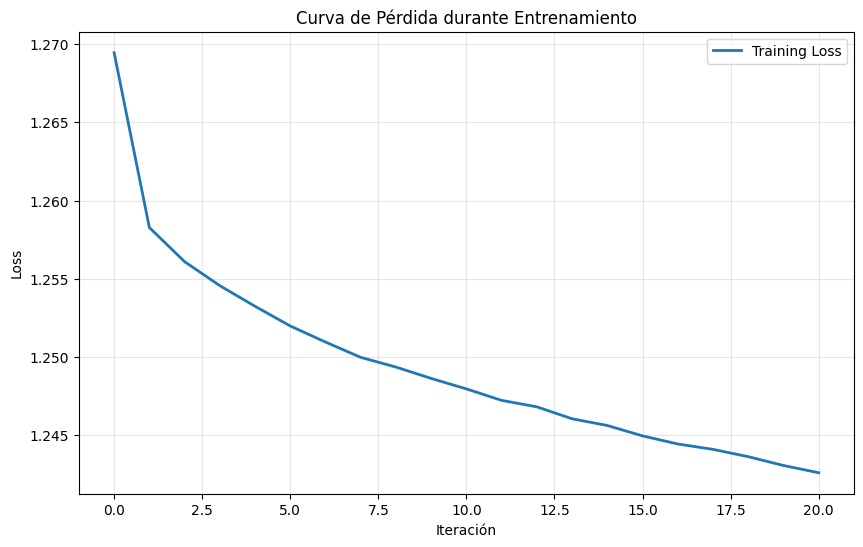

In [10]:
# Curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(model.loss_curve_, label='Training Loss', linewidth=2)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Curva de Pérdida durante Entrenamiento')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 8. Evaluación

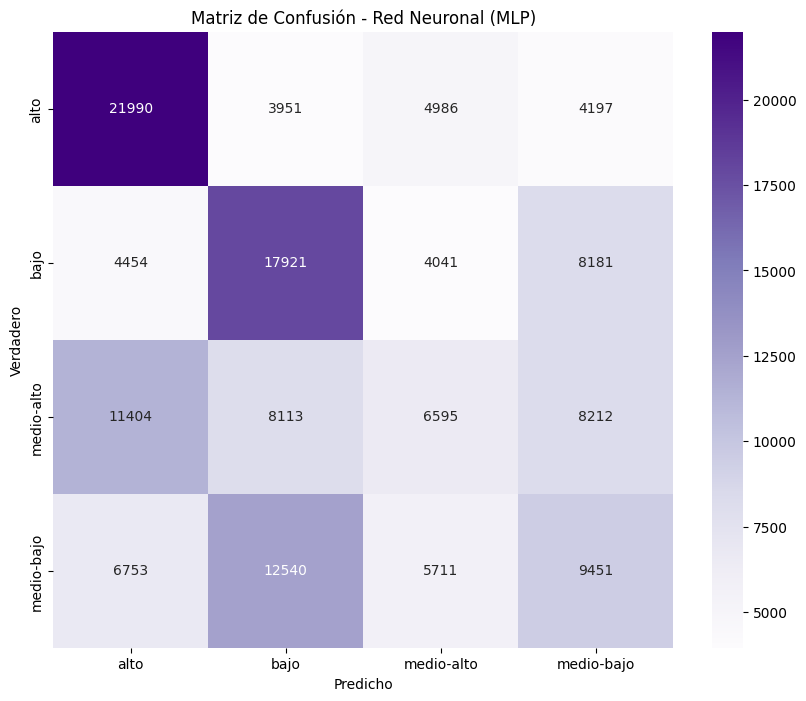


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.49      0.63      0.55     35124
        bajo       0.42      0.52      0.46     34597
  medio-alto       0.31      0.19      0.24     34324
  medio-bajo       0.31      0.27      0.29     34455

    accuracy                           0.40    138500
   macro avg       0.38      0.40      0.39    138500
weighted avg       0.39      0.40      0.39    138500



In [11]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Matriz de Confusión - Red Neuronal (MLP)')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_val, y_val_pred, target_names=le_target.classes_))

## 9. Generar Predicciones

In [12]:
# Preparar test
X_test = df_test_fe.copy()

# Asegurar mismas columnas
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# Normalizar test
X_test_scaled = scaler.transform(X_test)

# Predecir
y_test_pred_encoded = model.predict(X_test_scaled)
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

# Submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

submission.to_csv('submission_alt2.csv', index=False)

print("✓ Archivo submission_alt2.csv creado")
print("\nDistribución de predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index())

✓ Archivo submission_alt2.csv creado

Distribución de predicciones:
RENDIMIENTO_GLOBAL
alto          0.323607
bajo          0.307939
medio-alto    0.154465
medio-bajo    0.213989
Name: proportion, dtype: float64


## 10. Resumen

In [13]:
print("="*80)
print("ENFOQUE ALTERNATIVO 2: RED NEURONAL (MLP)")
print("="*80)

print(f"\n🧠 ARQUITECTURA:")
print(f"  - Input: {X.shape[1]} features")
print(f"  - Hidden Layer 1: 128 neuronas (ReLU)")
print(f"  - Hidden Layer 2: 64 neuronas (ReLU)")
print(f"  - Output: 4 clases (softmax)")
print(f"  - Total parámetros: ~{(X.shape[1]*128 + 128*64 + 64*4):,}")

print(f"\n🔧 DIFERENCIAS vs Modelo Solución:")
print(f"  - StandardScaler para normalización")
print(f"  - MLPClassifier en lugar de Random Forest")
print(f"  - Early stopping para evitar overfitting")
print(f"  - Learning rate adaptativo")
print(f"  - Feature engineering básico")

print(f"\n📊 RESULTADOS:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")
print(f"  Iteraciones: {model.n_iter_}")

print(f"\n💡 VENTAJAS:")
print(f"  + Puede capturar relaciones no lineales complejas")
print(f"  + Normalización mejora convergencia")
print(f"  + Early stopping previene overfitting")

print(f"\n⚠️ DESVENTAJAS:")
print(f"  - Entrenamiento más lento")
print(f"  - Requiere normalización")
print(f"  - Menos interpretable")
print(f"  - Sensible a hiperparámetros")

print("\n" + "="*80)

ENFOQUE ALTERNATIVO 2: RED NEURONAL (MLP)

🧠 ARQUITECTURA:
  - Input: 20 features
  - Hidden Layer 1: 128 neuronas (ReLU)
  - Hidden Layer 2: 64 neuronas (ReLU)
  - Output: 4 clases (softmax)
  - Total parámetros: ~11,008

🔧 DIFERENCIAS vs Modelo Solución:
  - StandardScaler para normalización
  - MLPClassifier en lugar de Random Forest
  - Early stopping para evitar overfitting
  - Learning rate adaptativo
  - Feature engineering básico

📊 RESULTADOS:
  Train Accuracy: 0.4109
  Validation Accuracy: 0.4040
  Iteraciones: 21

💡 VENTAJAS:
  + Puede capturar relaciones no lineales complejas
  + Normalización mejora convergencia
  + Early stopping previene overfitting

⚠️ DESVENTAJAS:
  - Entrenamiento más lento
  - Requiere normalización
  - Menos interpretable
  - Sensible a hiperparámetros

